# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)
print("done")

56
done



# Data preparation

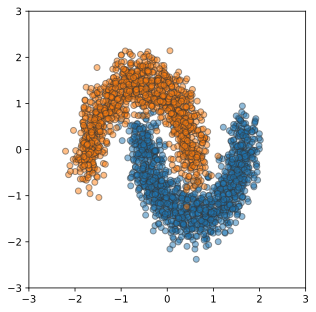

done


In [41]:
data_noise = 0.15
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')
print("done")

## Model dynamics

In [42]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 4, 5
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'outside' #outside

## Training and generating level sets

In [43]:
import torch


num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

In [44]:
anode

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)

In [45]:
print(anode)

anode.print_to_file('test.txt')

tanh(w(t)x(t)+b(t))    over the interval t = [0, 4],

W[0] = [[ 0.64080113  0.08583963]
 [-0.20712656  0.63004214]],        b[0] = [-0.04579896  0.32258552]

W[1] = [[-0.31685847 -0.037579  ]
 [ 0.3370002   0.03979158]],        b[1] = [-0.393597    0.38825458]

W[2] = [[-0.07144028 -0.32166535]
 [-0.13505656  0.17775238]],        b[2] = [0.12609655 0.02040184]

W[3] = [[-0.33295402 -0.24659514]
 [-0.01392382 -0.2862049 ]],        b[3] = [-0.6161037  -0.40715516]

W[4] = [[ 0.08449179 -0.24806759]
 [ 0.18409109  0.3868479 ]],        b[4] = [ 0.38401514 -0.21548226]




In [46]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)

/Users/queirolo/Desktop/GIT_repository/TUM_nODE/models/neural_odes.py:111: UserWarning: Extending the dynamics
  warn('Extending the dynamics')



Iteration 0/38
Loss: 2.034

Iteration 10/38
Loss: 1.911

Iteration 20/38
Loss: 1.930

Iteration 30/38
Loss: 1.789
Epoch 1: 1.828

Iteration 0/38
Loss: 1.687

Iteration 10/38
Loss: 1.582

Iteration 20/38
Loss: 1.674

Iteration 30/38
Loss: 1.566
Epoch 2: 1.577

Iteration 0/38
Loss: 1.534

Iteration 10/38
Loss: 1.531

Iteration 20/38
Loss: 1.358

Iteration 30/38
Loss: 1.327
Epoch 3: 1.361

Iteration 0/38
Loss: 1.315

Iteration 10/38
Loss: 1.086

Iteration 20/38
Loss: 1.172

Iteration 30/38
Loss: 1.048
Epoch 4: 1.166

Iteration 0/38
Loss: 1.129

Iteration 10/38
Loss: 1.050

Iteration 20/38
Loss: 1.117

Iteration 30/38
Loss: 0.894
Epoch 5: 1.004

Iteration 0/38
Loss: 0.951

Iteration 10/38
Loss: 0.777

Iteration 20/38
Loss: 0.881

Iteration 30/38
Loss: 0.766
Epoch 6: 0.883

Iteration 0/38
Loss: 1.208

Iteration 10/38
Loss: 0.709

Iteration 20/38
Loss: 1.213

Iteration 30/38
Loss: 0.600
Epoch 7: 0.816

Iteration 0/38
Loss: 0.830

Iteration 10/38
Loss: 0.532

Iteration 20/38
Loss: 0.698

Ite

In [47]:
print(anode)

tanh(w(t)x(t)+b(t))    over the interval t = [0, 4],

W[0] = [[ 0.27842075  0.4496384 ]
 [-0.13259408  0.04104559]],        b[0] = [-0.27893752 -0.2185578 ]

W[1] = [[-2.016309   -0.09179159]
 [ 1.92433    -0.6070335 ]],        b[1] = [-0.43563297  0.30985716]

W[2] = [[ 1.4446803  -1.2928253 ]
 [-1.6261101   0.93070304]],        b[2] = [ 0.15369496 -0.25130412]

W[3] = [[ 0.68664074 -1.0726228 ]
 [-0.690348   -0.00929716]],        b[3] = [-0.19133918 -0.05579871]

W[4] = [[ 0.08449179 -0.24806759]
 [ 0.18409109  0.3868479 ]],        b[4] = [ 0.38401514 -0.21548226]




### Check the basins of attraction

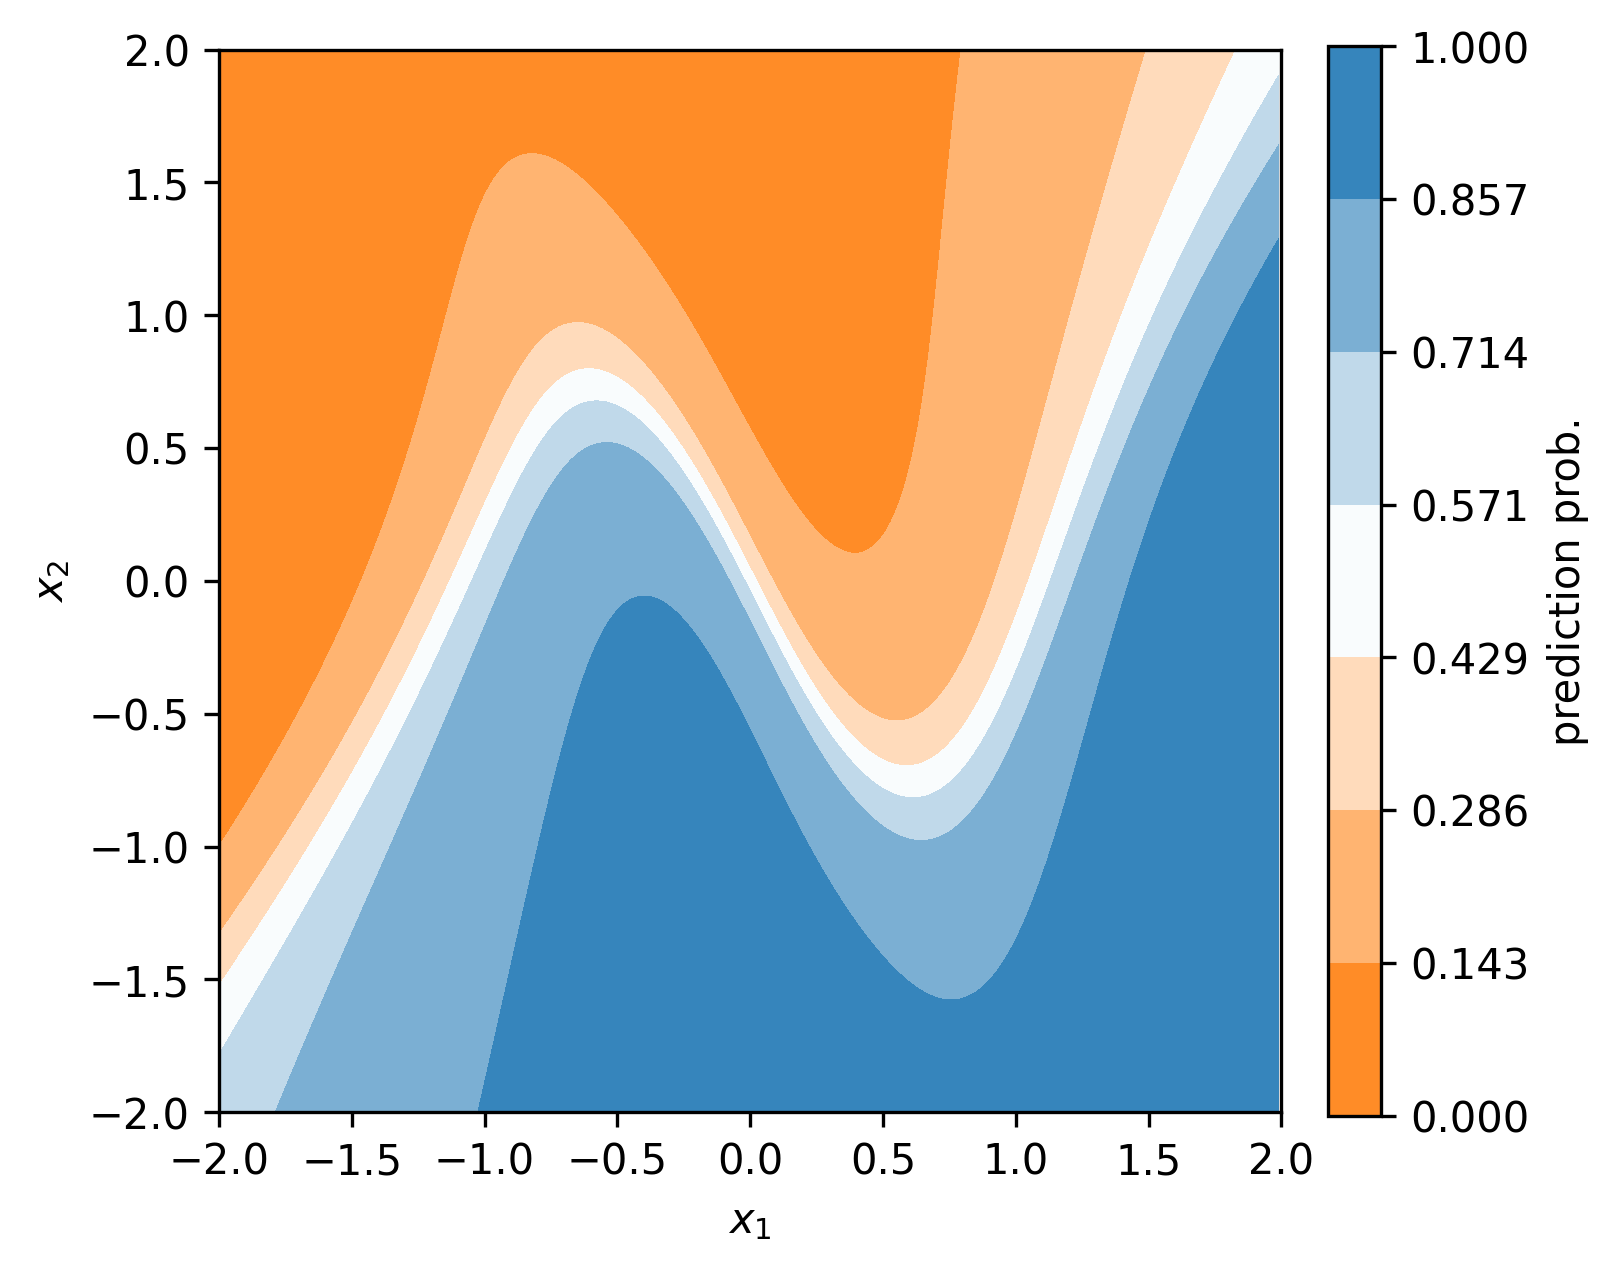

In [48]:
from plots.plots import classification_levelsets

classification_levelsets(anode, 'classification_levelsets')

from IPython.display import Image

img1 = Image(filename = 'classification_levelsets' + '.png', width = 400)
display(img1)

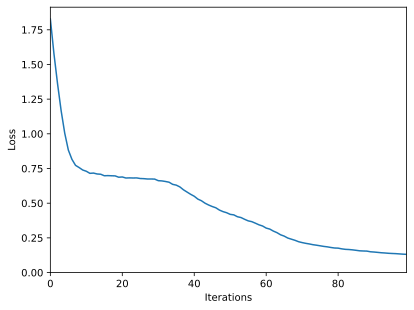

In [50]:
from plots.plots import classification_levelsets

plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [7]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate

tensor([[-1.3000,  0.5603],
        [-0.3255, -1.1165],
        [-1.2043,  0.4415],
        [ 1.7537,  0.1016],
        [ 0.5258,  0.6008]])
torch.Size([10, 5, 2])


## Computation of the Maximal Lyapunov Exponent by integration 

In [51]:
from Lyapunov_toolbox import local_FTLE


Results for 1D linear
Refined implementation 
 [1.00000002] VS 1


Results for Lorentz


/Users/queirolo/.local/share/virtualenvs/TUM_nODE-bBJE3WN-/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Refined implementation 
 [ 0.58616832 -0.01338886 -6.73747332] VS 0.90

Results for Rossler show convergence over time
Refined implementation t=100
 [ 4.37290283e-02  3.43598679e-03 -6.11785336e+00] VS 0.0714, 0, -5.3943
Refined implementation t=500
 [ 0.02838772  0.00161654 -1.58576315] VS 0.0714, 0, -5.3943
Refined implementation t=1500
 [ 0.00955888  0.00067687 -0.53484937] VS 0.0714, 0, -5.3943


In [121]:
import time

# sanity check:
l = local_FTLE(anode, np.array([0.1,-0.5]), 19, 0.1)
print(l)

x_amount = 100
integration_time = T 
dt = 0.1

x = np.linspace(-2,2,x_amount)
y = np.linspace(-2,2,x_amount)
X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()])

lyap2 = np.zeros(x_amount**2)
start_time = time.time()
for i in range(x_amount**2):
    lyap2[i] = np.max(local_FTLE(anode, XY[:,i], 20, 0.1))
    iteration_time = time.time() - start_time
    if np.mod(i, 10) == 0:
        print(i+1,' out of ', x_amount**2, ' after ', iteration_time)
    # print(lyap[i])
    #break
lyap2 = np.reshape(lyap2, (x_amount,x_amount))
print(lyap2)

[-0.00024839  0.03694649]


/Users/queirolo/Desktop/GIT_repository/TUM_nODE/models/neural_odes.py:110: UserWarning: Extending the dynamics
  warn('Extending the dynamics')


1  out of  10000  after  0.9564659595489502
11  out of  10000  after  10.24271011352539
21  out of  10000  after  19.310133934020996
31  out of  10000  after  28.668270111083984
41  out of  10000  after  37.79765820503235
51  out of  10000  after  46.75964593887329
61  out of  10000  after  55.56922388076782
71  out of  10000  after  64.64094686508179
81  out of  10000  after  73.44279599189758
91  out of  10000  after  82.34301424026489
101  out of  10000  after  91.24978113174438
111  out of  10000  after  100.33787488937378
121  out of  10000  after  109.08496308326721
131  out of  10000  after  117.81926107406616
141  out of  10000  after  126.60643720626831
151  out of  10000  after  135.72070717811584
161  out of  10000  after  144.59312105178833
171  out of  10000  after  153.3744351863861
181  out of  10000  after  161.93034601211548
191  out of  10000  after  170.6460621356964
201  out of  10000  after  179.40113401412964
211  out of  10000  after  188.3105890750885
221  out o

ValueError: cannot reshape array of size 400 into shape (100,100)

In [122]:
lyap2 = np.reshape(lyap2, (x_amount,x_amount))

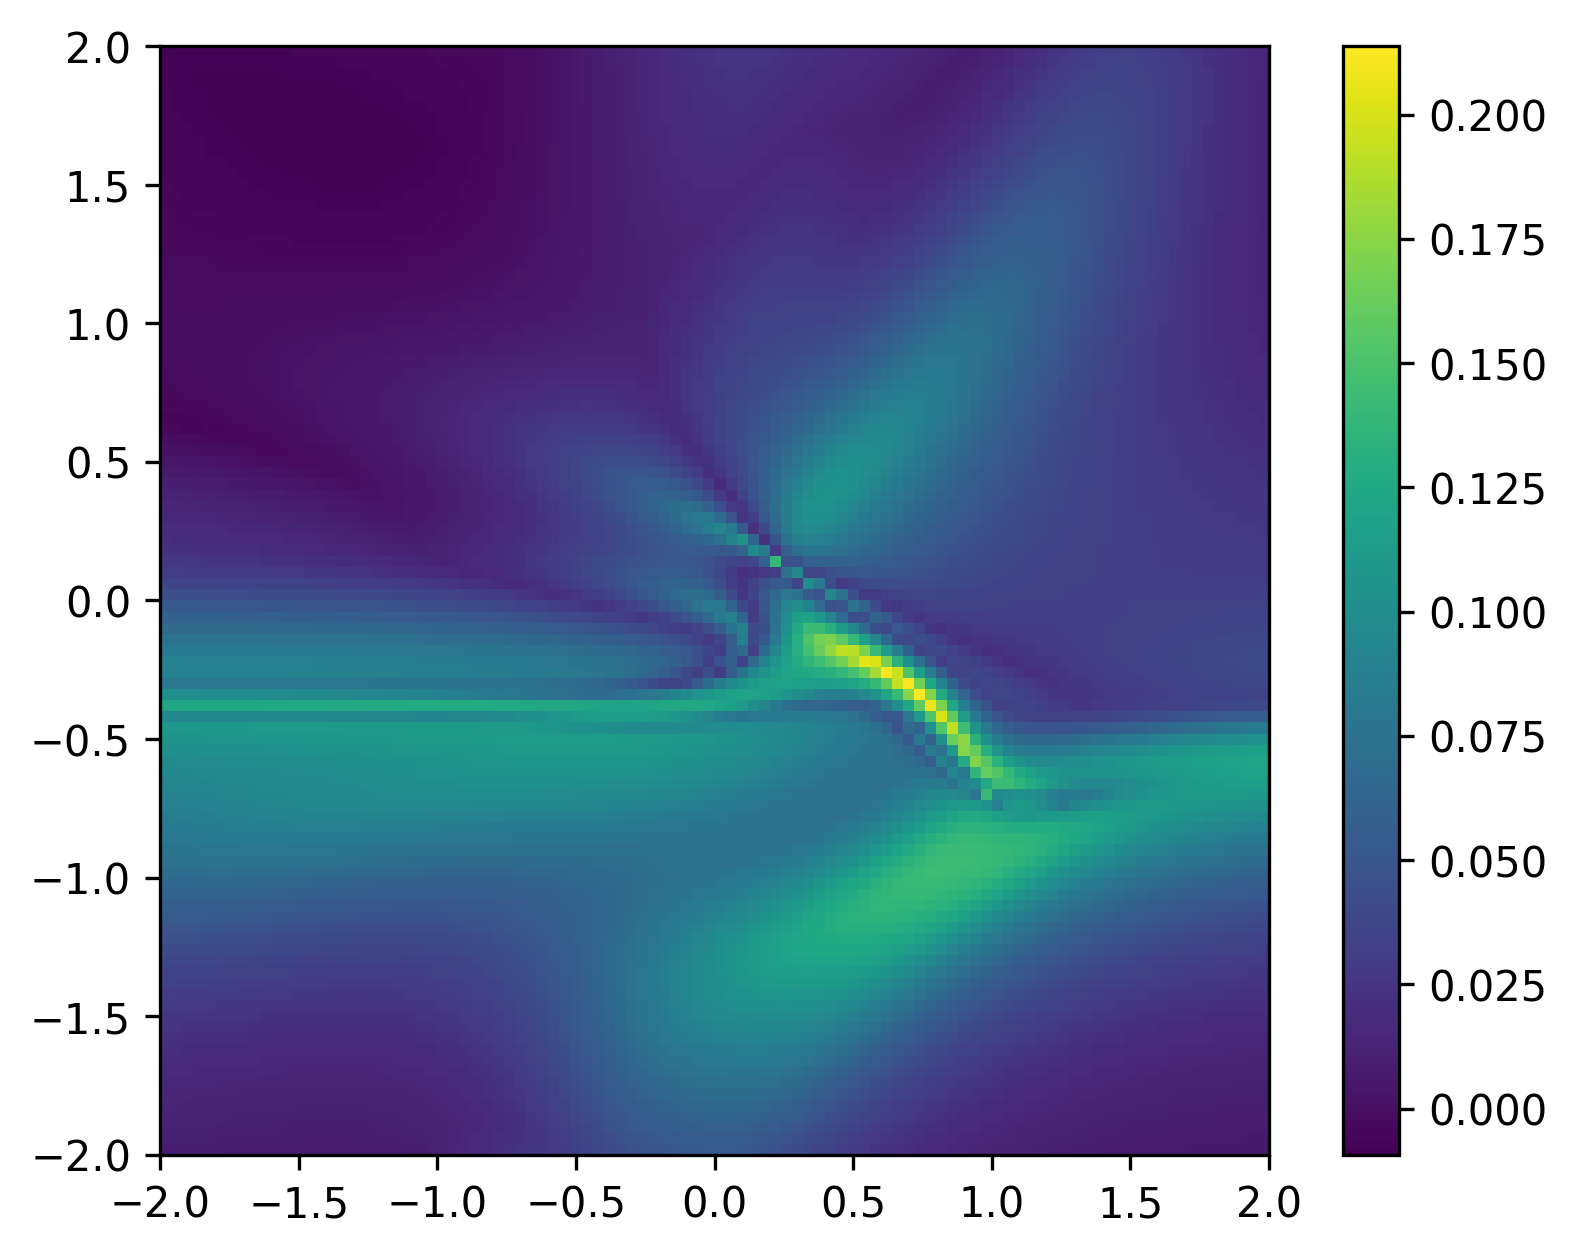

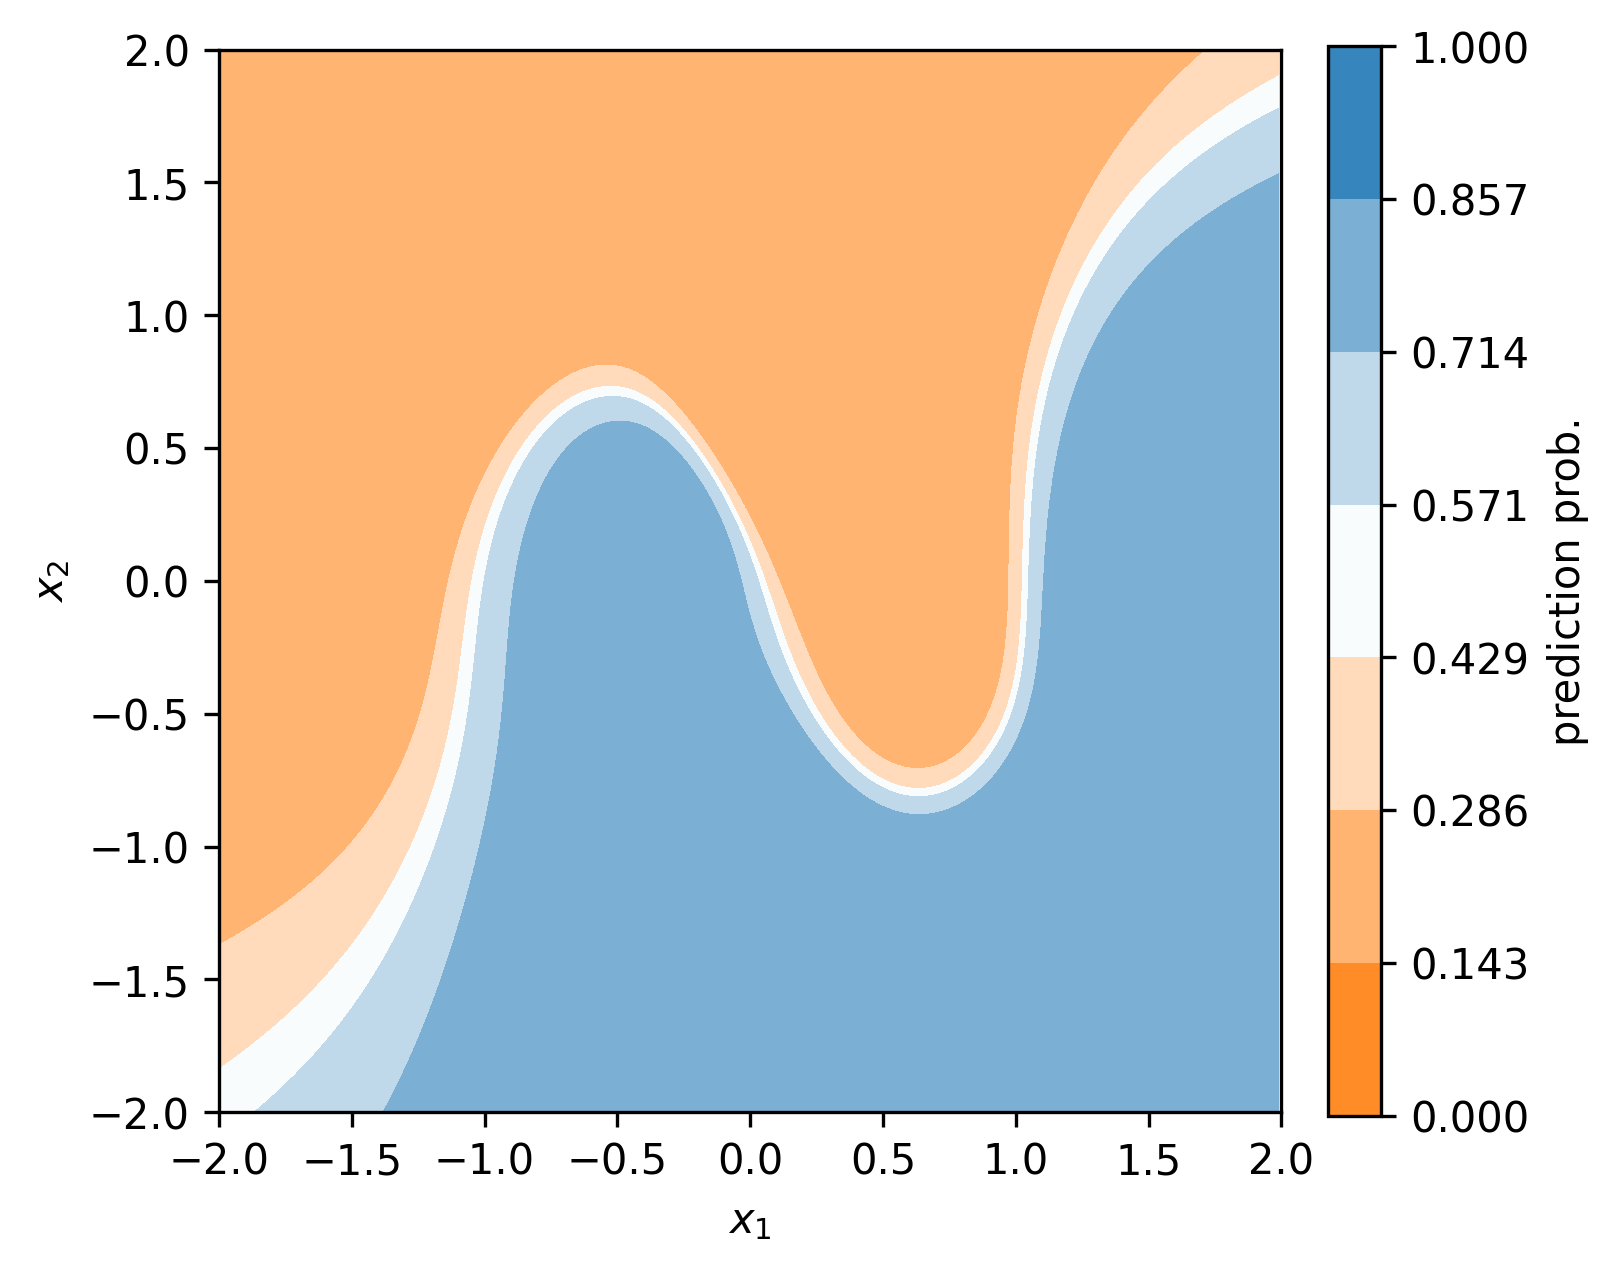

In [123]:
# Create heatmap using imshow
from IPython.display import Image

file_name = 'MLE_analytic_7.png'

anodeimg = plt.imshow(np.rot90(lyap2), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig(file_name, bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(file_name, width = 400)
display(img1)

img1 = Image(filename = 'classification_levelsets' + '.png', width = 400)
display(img1)

/Users/queirolo/Desktop/GIT_repository/TUM_nODE/models/neural_odes.py:110: UserWarning: Extending the dynamics
  warn('Extending the dynamics')


[-0.01073847  0.03335066]


/Users/queirolo/Desktop/GIT_repository/TUM_nODE/models/neural_odes.py:110: UserWarning: Extending the dynamics
  warn('Extending the dynamics')


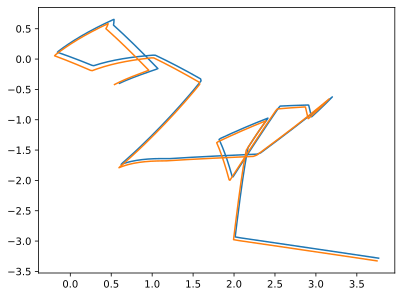

In [118]:
def func(x,t):
    x_torch = torch.from_numpy(x).type(torch.float32)
    x_torch.requires_grad=True
    f_x_torch = anode.flow.dynamics.forward(t, x_torch)
    f_x_torch = f_x_torch.detach().numpy()
    return f_x_torch


x = np.array([0.6, -0.4])

print(local_FTLE(anode, x, 20, 0.1))

x_torch = torch.from_numpy(x).type(torch.float32)

trajectories = anode.flow.trajectory(x_torch, 5000).detach()
x_t = scipy.integrate.odeint(func, x, np.linspace(0,20,500))

plt.plot(trajectories[:,0],trajectories[:,1])
plt.plot(x_t[:,0],x_t[:,1])
plt.show()

x = x - np.array([0.06, 0.02])
x_torch = torch.from_numpy(x).type(torch.float32)

#trajectories = anode.flow.trajectory(x_torch, 200).detach()

#plt.plot(trajectories[:,0],trajectories[:,1])
x_t = scipy.integrate.odeint(func, x, np.linspace(0,20,500))

#plt.plot(trajectories[:,0],trajectories[:,1])
#plt.plot(x_t[:,0],x_t[:,1])

#plt.show()

In [ ]:
with open('Lyap2_pic_data_for_RNN.npy', 'wb') as f:
    np.save(f, lyap2)

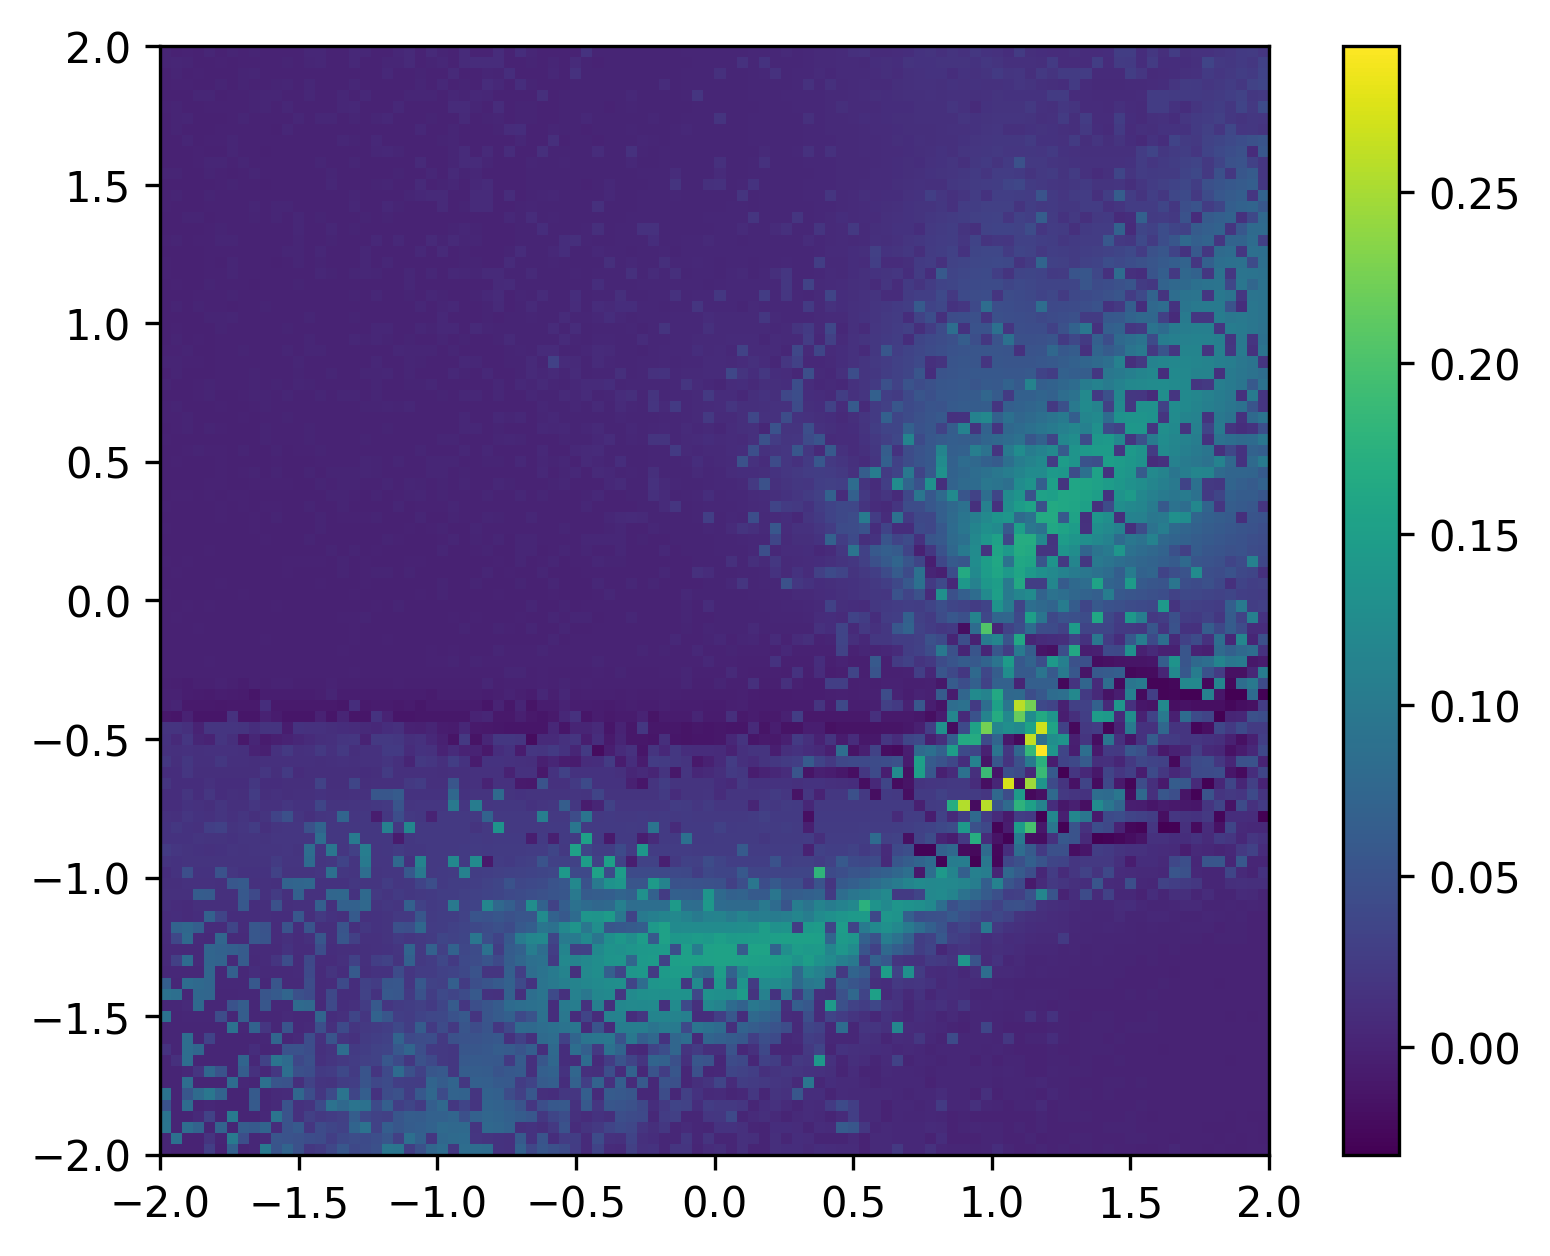

In [59]:
with open('Lyap_pic_data_for_RNN.npy', 'rb') as f:
    lyap_load = np.load(f)

# Create heatmap using imshow
from IPython.display import Image

file_name = 'MLE_analytic_6.png'

anodeimg = plt.imshow(np.rot90(lyap_load), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig(file_name, bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(file_name, width = 400)
display(img1)

1  out of  10  after  0.023958683013916016
[-0.99999987 -0.99999987 -0.99999987 -0.99999987 -0.99999987  1.00000003
  1.00000003  1.00000003  1.00000003  1.00000003]


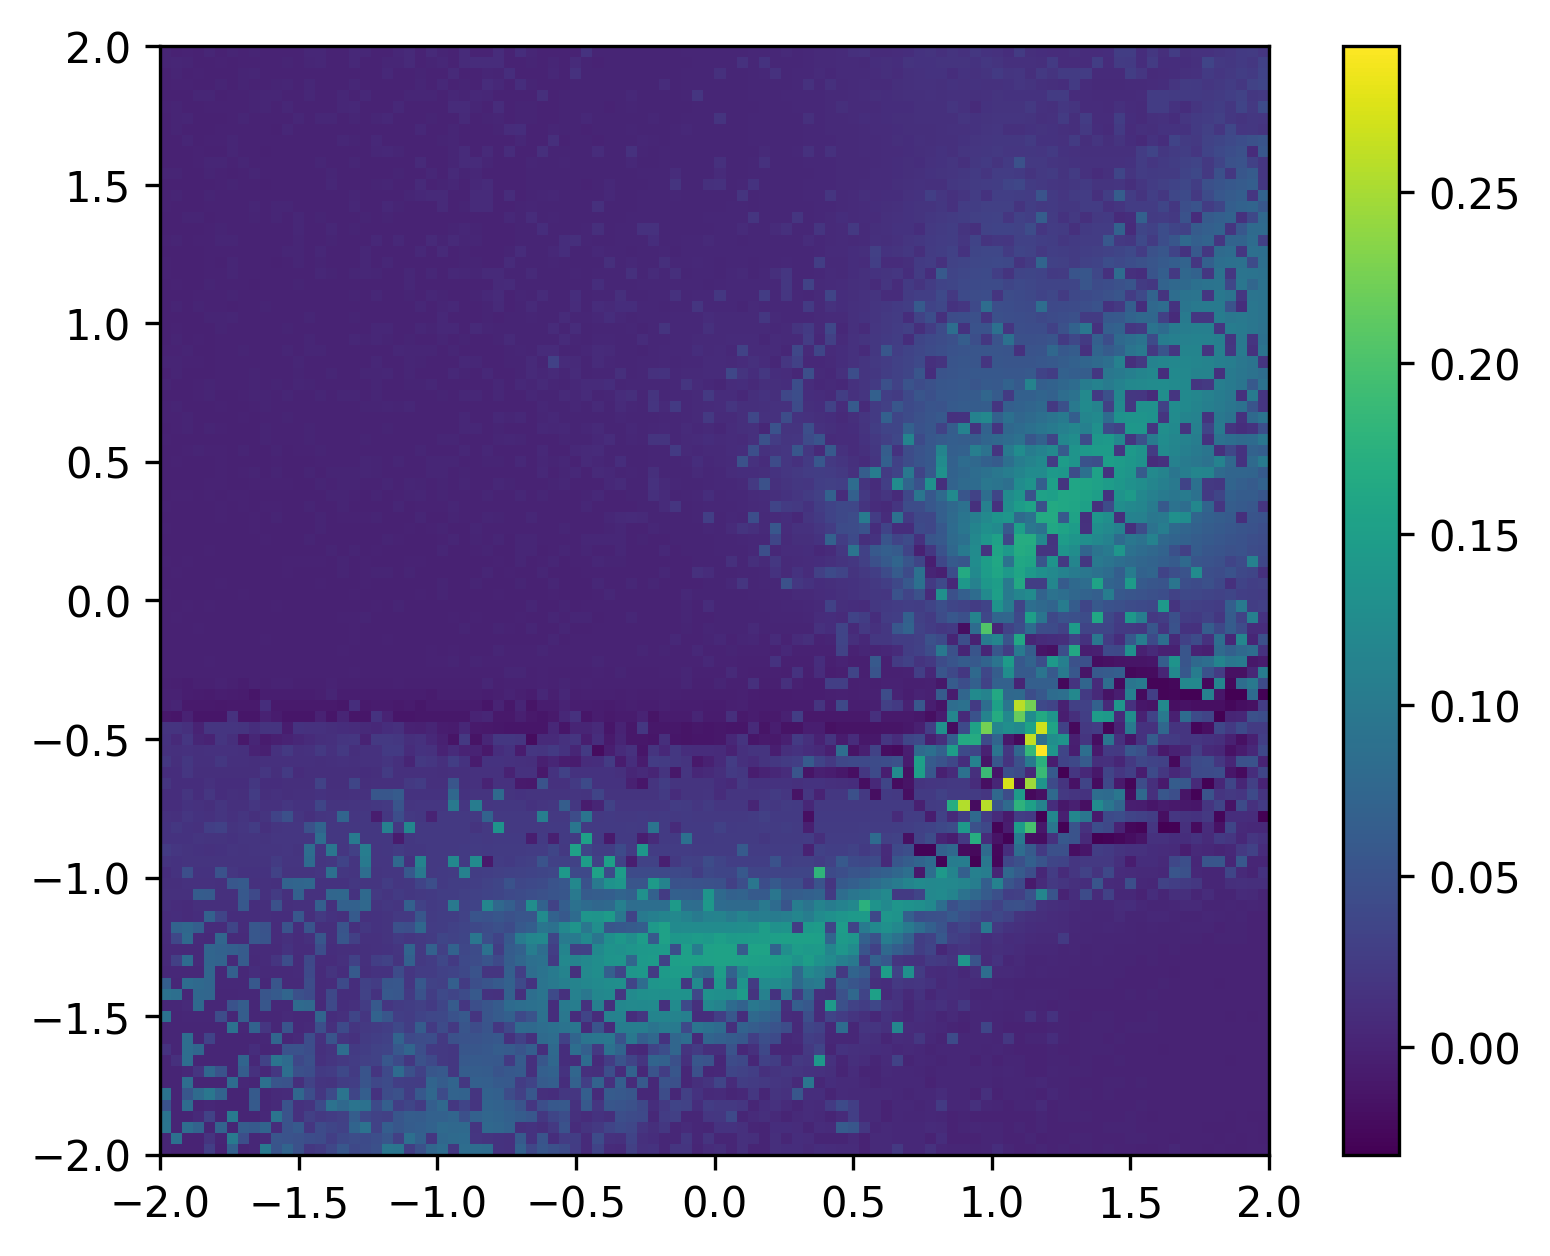

In [26]:
# Create heatmap using imshow
from IPython.display import Image

file_name = 'weirdODE_MLE_5.png'

anodeimg = plt.imshow(np.rot90(lyap_weird), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig(file_name, bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(file_name, width = 400)
display(img1)

In [34]:
import time

def weirdODE2D():
    def func(x, t):
        return np.abs(x) # expanding
    def der(x,t):
        return np.diagflat(np.sign(x)) # expanding
    return func, der



weird1D_func, weird1D_der = weirdODE2D()
local_FTLE(weird1D_func, np.array([1]), 60, 0.1, weird1D_der)

x_amount = 6
integration_time = T 
dt = 0.1

x = np.linspace(-2,2,x_amount)
y = np.linspace(-2,2,x_amount)
X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()])

lyap_abs2D = np.zeros(x_amount**2)
start_time = time.time()
for i in range(x_amount**2):
    lyap_abs2D[i] = np.max(local_FTLE(weird1D_func, XY[:,i], 20, 0.1,weird1D_der))
    iteration_time = time.time() - start_time
    if np.mod(i, 10) == 0:
        print(i+1,' out of ', x_amount**2, ' after ', iteration_time)
    # print(lyap[i])
    #break
lyap_abs2D = np.reshape(lyap_abs2D, (x_amount,x_amount))
print(lyap_abs2D)

1  out of  36  after  0.025907278060913086
11  out of  36  after  0.24333524703979492
21  out of  36  after  0.4551060199737549
31  out of  36  after  0.6813220977783203
[[-0.99999987 -0.99999987 -0.99999987  1.00000003  1.00000003  1.00000003]
 [-0.99999987 -0.99999987 -0.99999987  1.00000003  1.00000003  1.00000003]
 [-0.99999987 -0.99999987 -0.99999987  1.00000003  1.00000003  1.00000003]
 [ 1.00000003  1.00000003  1.00000003  1.00000003  1.00000003  1.00000003]
 [ 1.00000003  1.00000003  1.00000003  1.00000003  1.00000003  1.00000003]
 [ 1.00000003  1.00000003  1.00000003  1.00000003  1.00000003  1.00000003]]


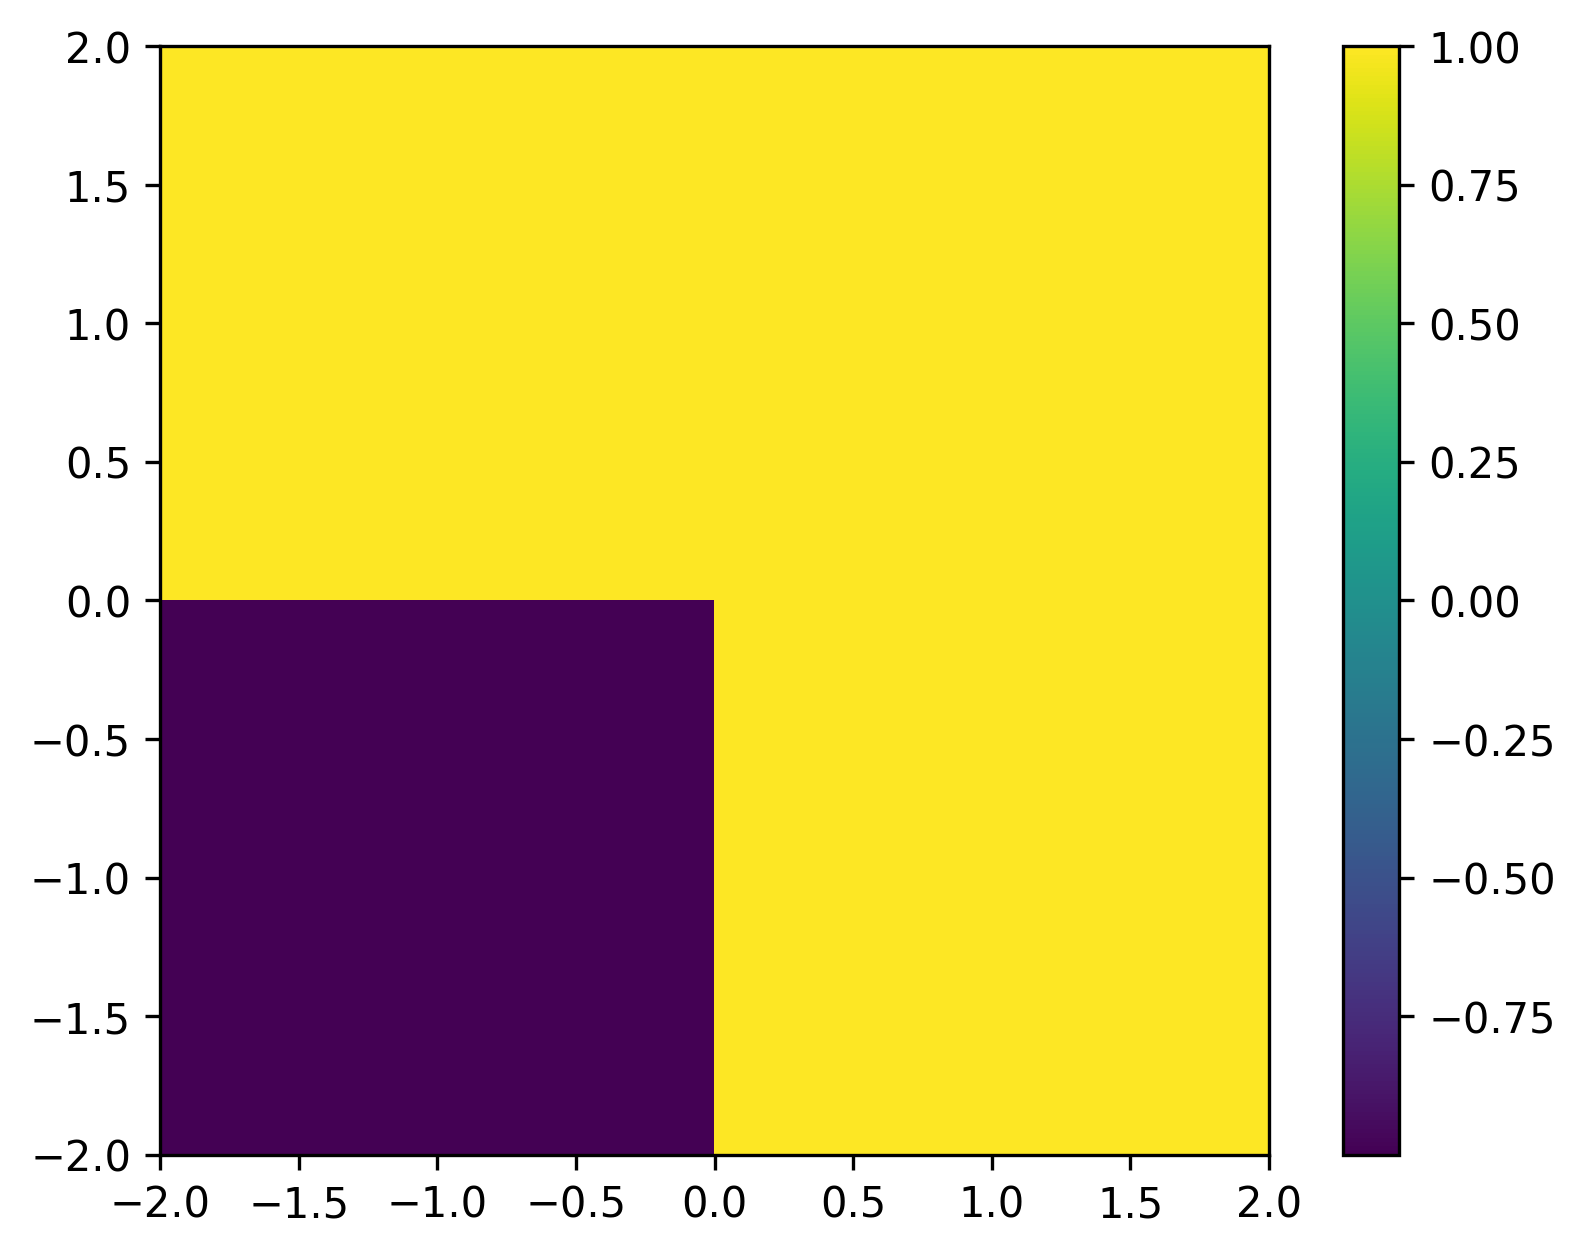

In [35]:
# Create heatmap using imshow
from IPython.display import Image

file_name = 'weirdODE2D_MLE_5.png'

anodeimg = plt.imshow(np.rot90(lyap_abs2D), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig(file_name, bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(file_name, width = 400)
display(img1)

In [126]:
# testing the auto grad function 
testing = False
if testing:
    w = torch.rand(2,2)
    b = torch.rand(2)
    print(w, b)
    def exp_reducer(x):
         return torch.matmul(w, x) + b

    inputs = torch.rand(2)

    print(torch.autograd.functional.jacobian(exp_reducer, inputs))

In [127]:
# TESTING 
testing = False
if testing:
    x = np.array([1., 2.]) # point where we compute the MLE
    Jac = np.identity(2)     # vector with appropriate size
    x_and_Jac = np.concatenate((x,Jac.flatten())).astype(np. double)
    dt = 0.1
    integration_time = 1.
    time_array = np.arange(0, integration_time, dt)
    debug_MLE = False
    f_x = anode.flow.dynamics.forward
    f_x(integration_time, torch.from_numpy(x).type(torch.float32)) # this now works
    CLO = linear_dynamics(anode)
    CLO(x_and_Jac, integration_time)

    out = scipy.integrate.odeint(linear_dynamics(anode), x_and_Jac, time_array)
    # out has one entry for each time

    # we are only interested in the last time integration, that we reshape as a matrix
    L = np.reshape(out[-1,2:],[2,2])

    print('\nL = ', L)
    print('\nlog( L * L.T )= ', np.log(np.matmul(L, L.transpose())))
    
    lyap_exp = np.linalg.eig( 1/(2*integration_time) * np.log(np.matmul(L, L.transpose())))
    
    print('\nLyap exps = ', lyap_exp.eigenvalues)
    
    # using the full function
    l = local_FTLE(anode, np.array([0.1,-0.5]), 1)
    print('Local FTLE = ', l)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

In [ ]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory39.png", 'standard training', "trajectory_db39.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()

In [ ]:
linlayer_levelsets(anode)

In [ ]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, duration = 500)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 40

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-5,5,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

# plt.scatter(X_viz[:,0],X_viz[:,1])

trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)

### comparison with other Lyapunov computation

In [124]:
'''
input: two trajectories x(t), y(t) where each has size (x_dim,len_t)
output: maximum lyapunov exponent for each time t, size (1,len_t)'''
def le(x,y,t):
    d = x - y
    d = torch.linalg.norm(x - y, dim = 0)
    # print(f'{d.shape = }')
    d = d/d[0]
    d = np.log(d)
    

    d = d/t
    return d



'''
Compute the maximum Lyapunov exponent with initial value tolerance eps
input: 
trajectories of size (x_amount,x_amount,x_dim,time_dim)
each trajectory has initial value x_0 = traj[i,j,:,0]

output:
MLE for each trajectory as averaged LE for all initial values that is eps close to the initial value
output size (x_amount,x_amount,t_dim)
'''
def MLE(traj, t, eps = 0.1):
    x_amount = traj.size(0)
    x_amount, y_amount, x_dim, t_dim = traj.shape
    le_val = torch.zeros((x_amount, y_amount, t_dim)) 
    print(f'{le_val.shape = }')
    for i in range(x_amount):
        for j in range(y_amount):
            count = 0
            for i_comp in range(x_amount):
                for j_comp in range(y_amount):
                    if (torch.norm(traj[i,j,:,0] - traj[i_comp,j_comp,:,0]) < eps and not(i == i_comp and j == j_comp)):
                        count += 1
                        le_val[i,j] += le(traj[i,j,:,:],traj[i_comp,j_comp,:,:],t)
                        print('avg le update with count ',count,' and value ',le_val[i,j,-1])
            if count > 1:
                le_val[i,j,:] = le_val[i,j,:]/count
    return le_val



In [125]:

x_amount = 100
eps = 0.08
t = torch.linspace(0,T,2) #only take initial and final time for MLE


x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)

inputs = torch.stack([X,Y], dim=-1)
print(f'{inputs.size() = }')
# print(inputs)

trajectories = anode.flow.trajectory(inputs, num_steps).detach()
t_indices = torch.tensor([0,-1])

trajectories = trajectories[t_indices] #only take the initial and final time of the trajectory
print('shape of trajectories of grid', trajectories.shape) #MLE works with the time in the last dimension
trajectories = trajectories.permute(1,2,3,0)
print('shape of permuted traj of grid', trajectories.shape) #this fits with the MLE function

output = MLE(trajectories,t,eps)
print(output)
output = output[:,:,-1] #reduce to last time instance T



inputs.size() = torch.Size([100, 100, 2])
shape of trajectories of grid torch.Size([2, 100, 100, 2])
shape of permuted traj of grid torch.Size([100, 100, 2, 2])
le_val.shape = torch.Size([100, 100, 2])
avg le update with count  1  and value  tensor(0.0205)
avg le update with count  2  and value  tensor(0.0392)
avg le update with count  3  and value  tensor(0.0214)
avg le update with count  1  and value  tensor(0.0205)
avg le update with count  2  and value  tensor(0.0415)
avg le update with count  3  and value  tensor(0.0754)
avg le update with count  4  and value  tensor(0.0940)
avg le update with count  5  and value  tensor(0.0777)
avg le update with count  1  and value  tensor(0.0210)
avg le update with count  2  and value  tensor(0.0426)
avg le update with count  3  and value  tensor(0.0766)
avg le update with count  4  and value  tensor(0.0951)
avg le update with count  5  and value  tensor(0.0804)
avg le update with count  1  and value  tensor(0.0216)
avg le update with count  2 

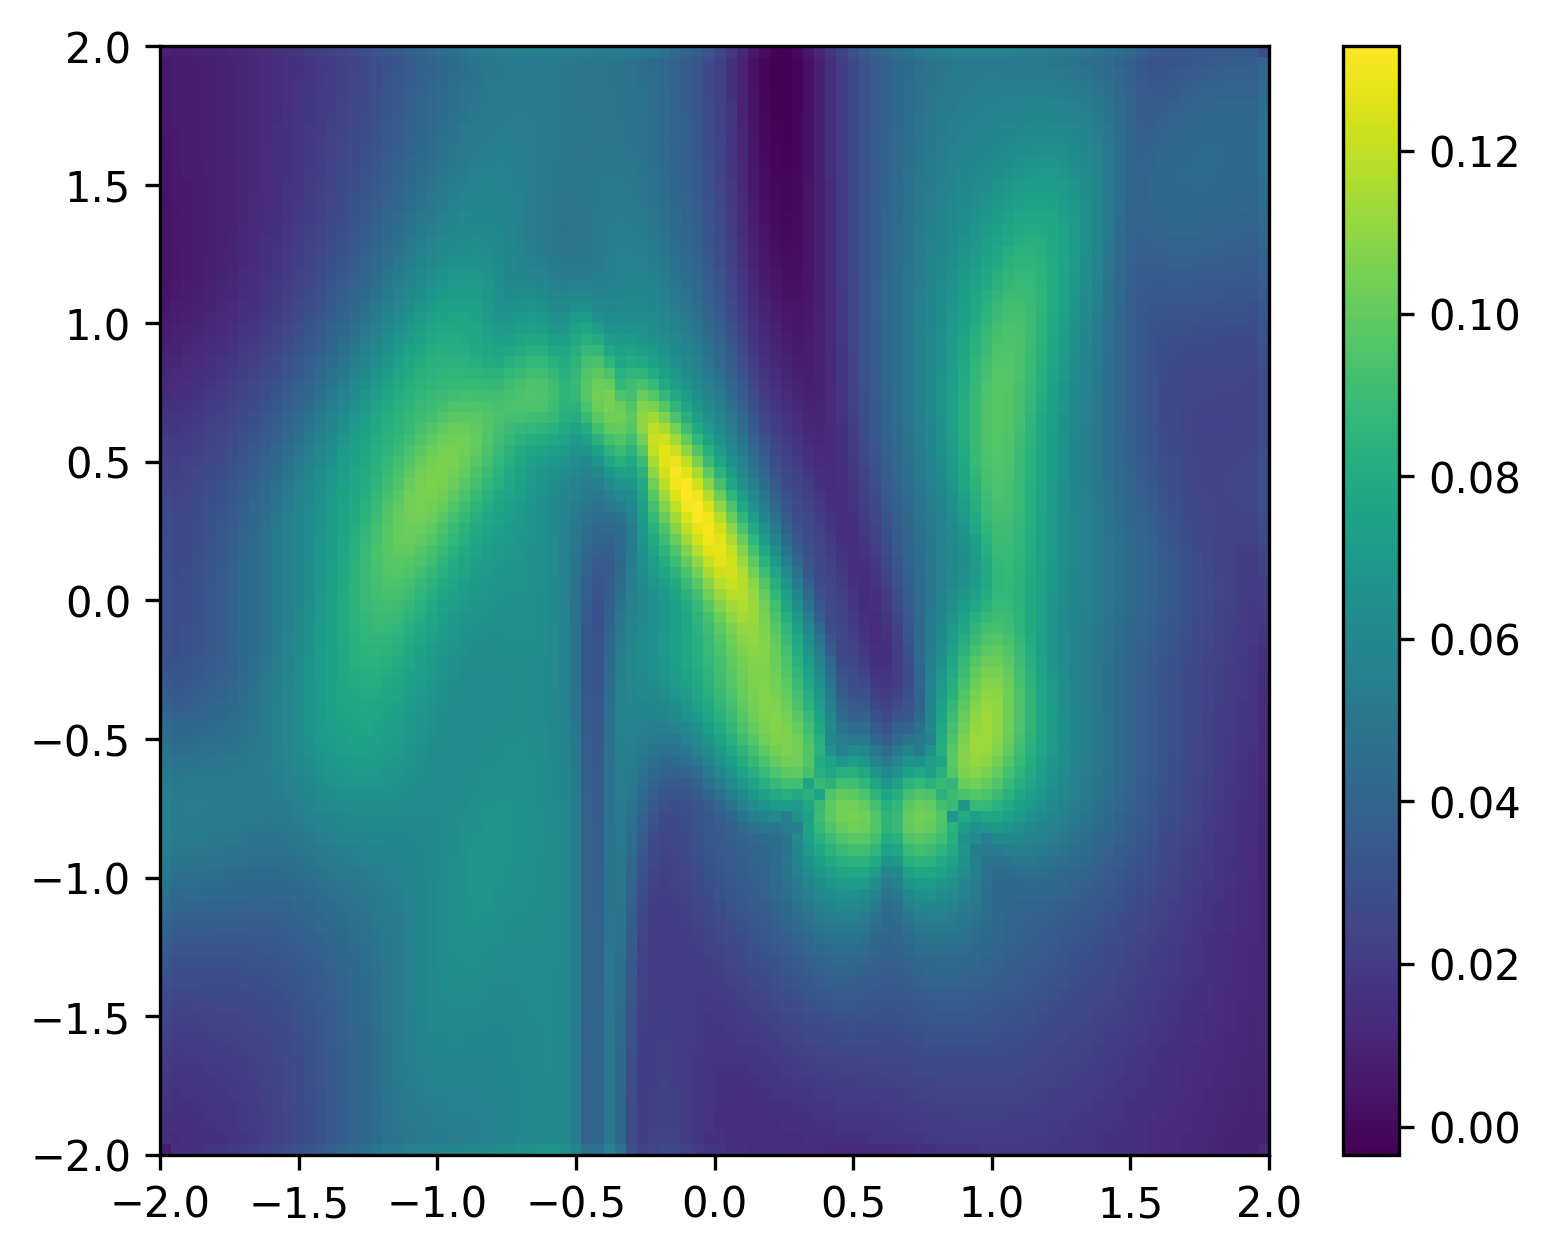

In [127]:
# Create heatmap using imshow
anodeimg = plt.imshow(np.rot90(output), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig('MLE.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img = Image(filename = 'MLE.png', width = 400)

display(img)

# compare output (from rough computation) and lyap2 (from more refined computation)

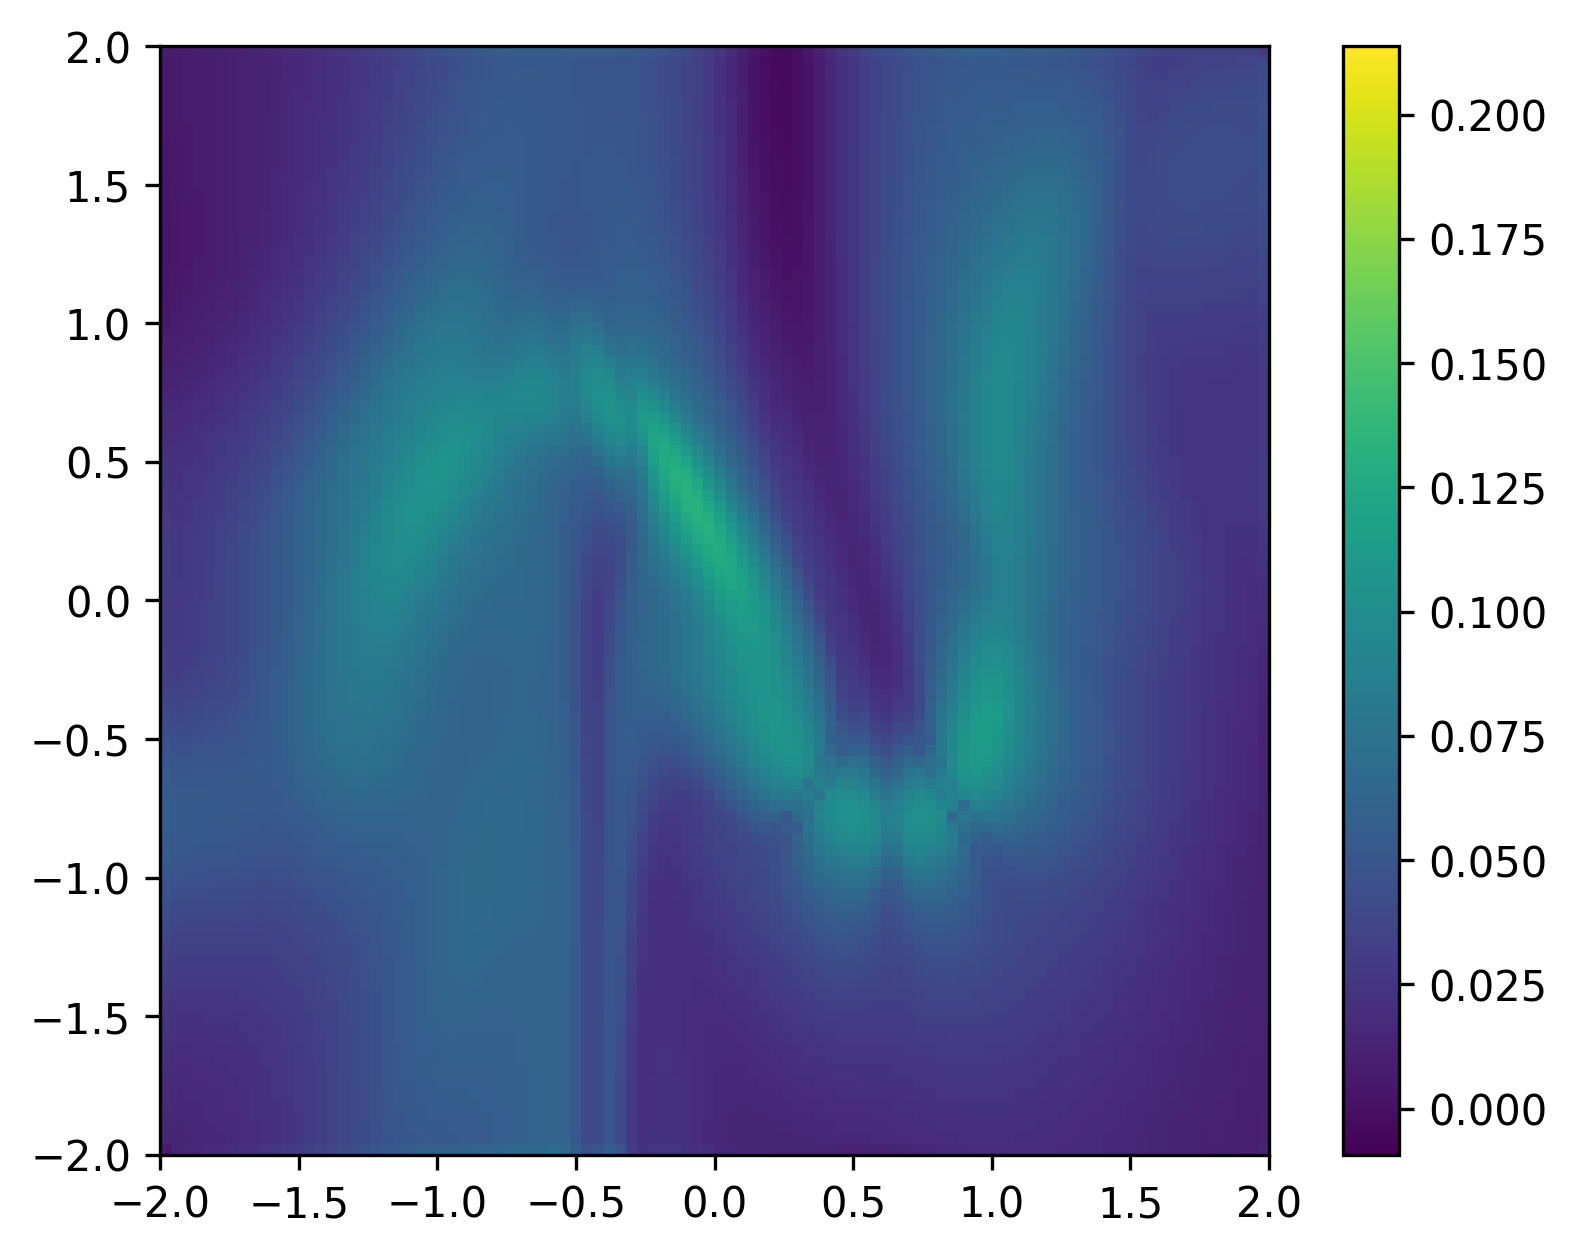

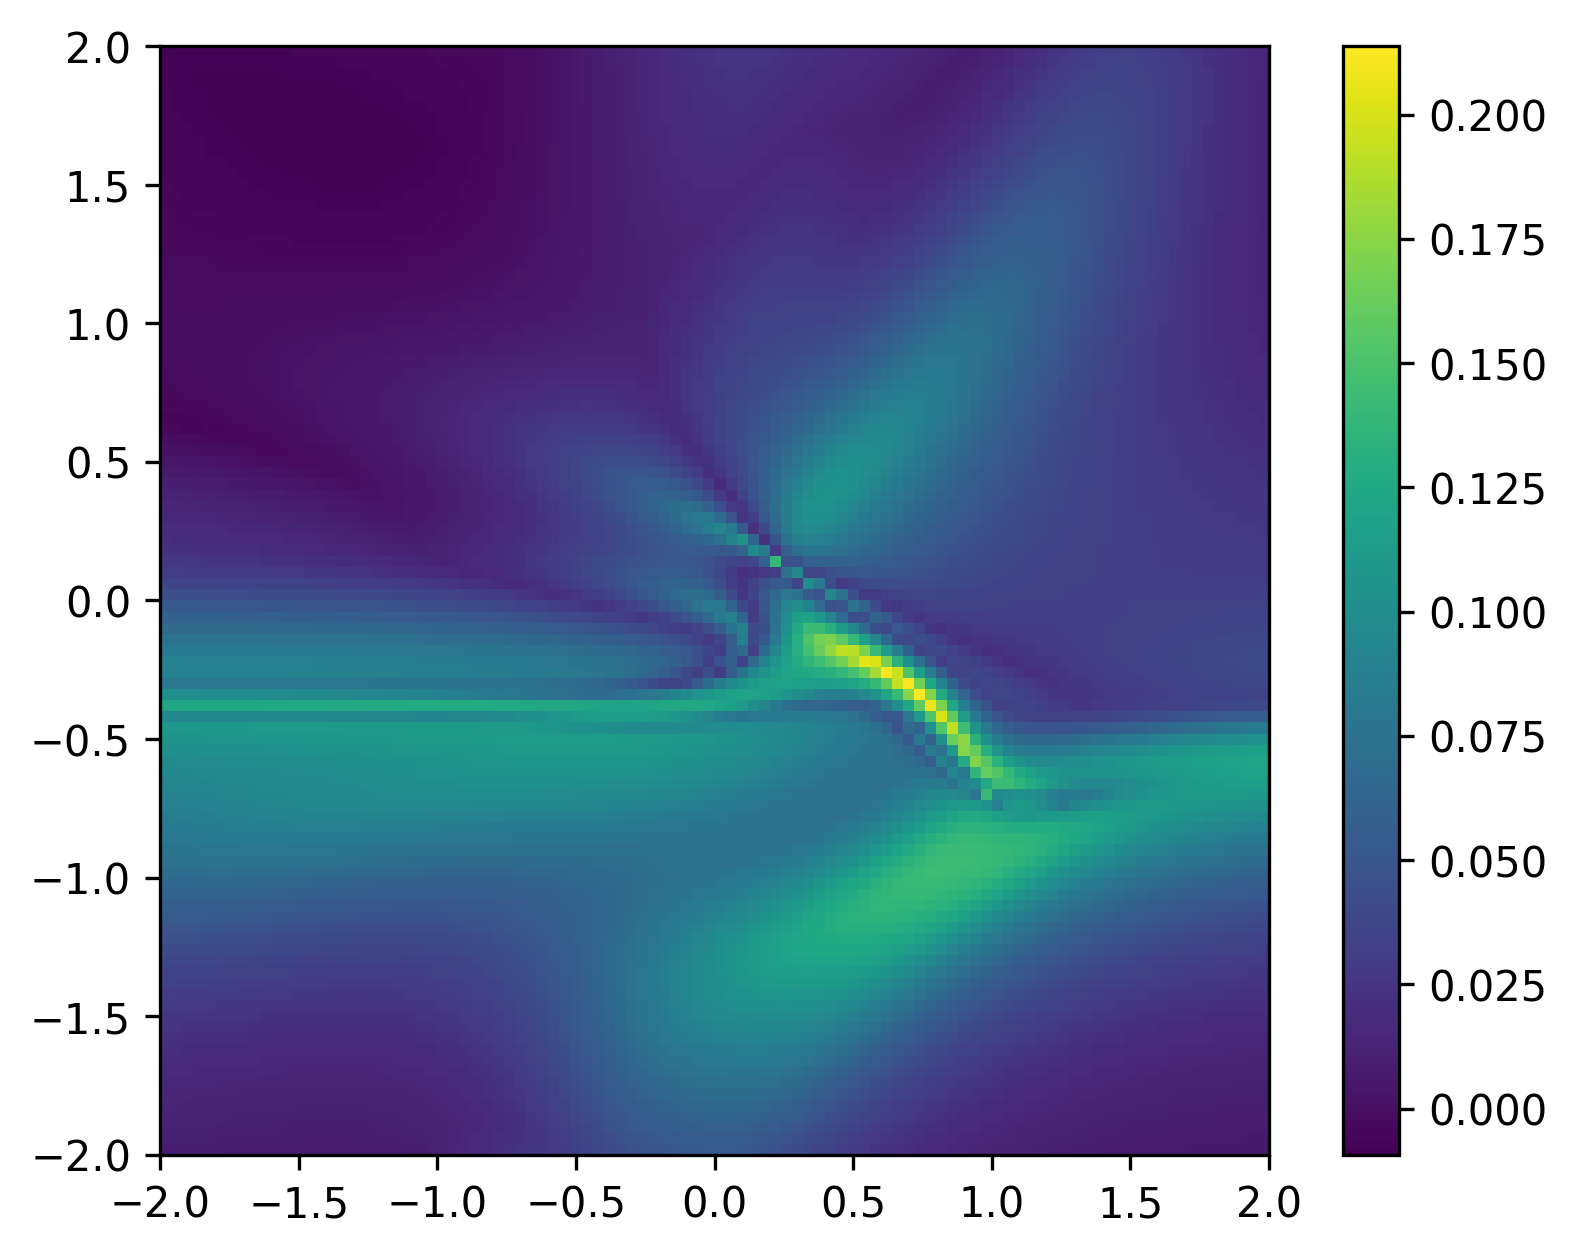

In [134]:
from matplotlib import colors


vmin = min([min(output.flatten()), min(lyap2.flatten())])
vmax = max([max(output.flatten()), max(lyap2.flatten())])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

anodeimg = plt.imshow(np.rot90(output), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
anodeimg.set_norm(norm)
plt.colorbar()
plt.savefig('MLE_rough.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

lyapimg = plt.imshow(np.rot90(lyap2), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
lyapimg.set_norm(norm)
plt.colorbar()
plt.savefig('MLE_integration.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = 'MLE_rough.png', width = 400)
img2 = Image(filename = 'MLE_integration.png', width = 400)

display(img1,img2)